In [15]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import Automate as au
import PIL
from PIL import Image
import glob

In [6]:
# Directory path
train_data_dir = 'chest_xray/train/NORMAL/'
train_data_dir_sick = 'chest_xray/train/PNEUMONIA/'

val_data_dir = 'chest_xray/val/NORMAL/'
val_data_dir_sick = 'chest_xray/val/PNEUMONIA/'

test_data_dir = 'chest_xray/test/NORMAL/'
test_data_dir_sick = 'chest_xray/test/PNEUMONIA/'

In [9]:
trainnorm_Counter = au.image_counter(train_data_dir)
trainsick_Counter = au.image_counter(train_data_dir_sick)
valnorm_Counter = au.image_counter(val_data_dir)
valsick_Counter = au.image_counter(val_data_dir_sick)
testnorm_Counter = au.image_counter(test_data_dir)
testsick_Counter = au.image_counter(test_data_dir_sick)

print(f"""Num of train normal images {trainnorm_Counter}
        Num of train sick images {trainsick_Counter}
        Num of val normal images {valnorm_Counter}
        Num of val sick images {valsick_Counter}
        Num of test normal images {testnorm_Counter}
        Num of test sick images {testsick_Counter}""")

Num of train normal images 1341
        Num of train sick images 3875
        Num of val normal images 8
        Num of val sick images 8
        Num of test normal images 234
        Num of test sick images 390


In [4]:
image = PIL.Image.open('chest_xray/test/NORMAL/IM-0001-0001.jpeg')

width, height = image.size
print(width, height)

1857 1317


normal picture title:  NORMAL2-IM-0914-0001.jpeg
pneumonia picture title: person259_virus_540.jpeg


Text(0.5, 1.0, 'Pneumonia')

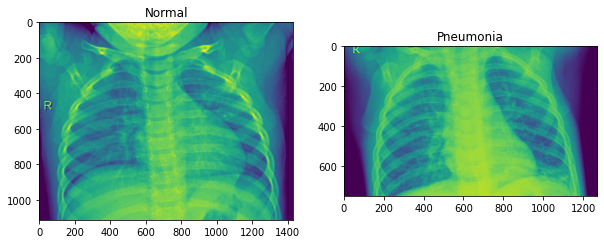

In [42]:
#Normal pic 
rand_norm= np.random.randint(2,len(os.listdir(train_data_dir)))

norm_pic = os.listdir(train_data_dir)[rand_norm]
norm_pic_address = train_data_dir+norm_pic
print('normal picture title: ',norm_pic)

#Pneumonia
rand_p = np.random.randint(2,len(os.listdir(train_data_dir_sick)))

sic_pic =  os.listdir(train_data_dir_sick)[rand_p]
sic_address = train_data_dir_sick+sic_pic
print('pneumonia picture title:', sic_pic)

# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)

#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')


a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load)
a2.set_title('Pneumonia')

In [8]:
# put images into a df 1 = pneumonia 0 = normal
traindf = au.images_to_df(train_data_dir, train_data_dir_sick)
traindf.head()

,image,label
0,person1537_virus_2674.jpeg,1
1,person328_bacteria_1513.jpeg,1
2,person815_bacteria_2726.jpeg,1
3,person1687_bacteria_4468.jpeg,1
4,NORMAL2-IM-0454-0001.jpeg,0


Text(0, 0.5, 'Count')

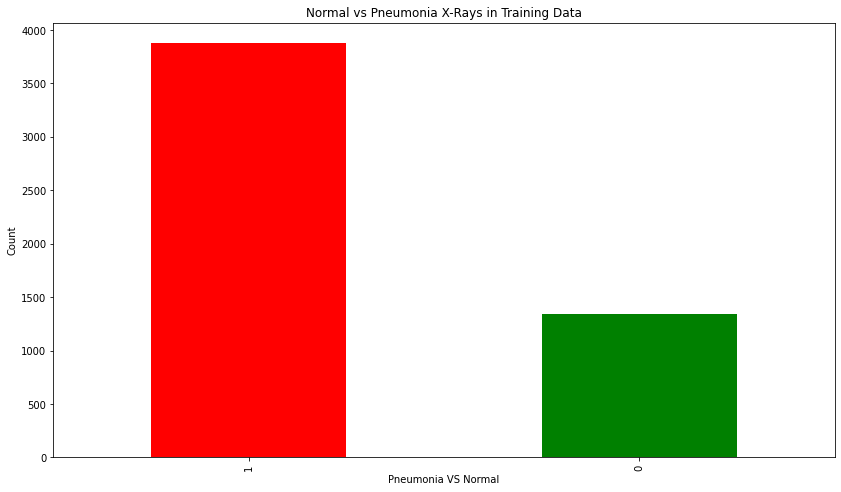

In [17]:
ax = traindf['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Normal vs Pneumonia X-Rays in Training Data",
                                         color = ('red', 'green'))
ax.set_xlabel("Pneumonia VS Normal")
ax.set_ylabel("Count")

In [ ]:
# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=132)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=790)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)